## Generate the ray

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from abc import ABC, abstractmethod

In [4]:
from typing import Tuple, Optional

# generate the ray's origin and direction (normalized)
def generate_rays(w:int, h:int, f) -> Tuple[np.ndarray, np.ndarray]:
    # origin is zeros
    ray_o = np.zeros(((w*h), 3))

    u, v = np.arange(w), np.arange(h)
    # assert (u.shape[0], v.shape[0]) == (w, h)
    u, v = np.meshgrid(u, v)
    # print(u.shape, v.shape) # (h, w) (h, w)

    # move 'u, v' to the center. and reflect along axis y.
    # [u, v, f]
    ray_d = np.stack(((u - w/2), -(v - h/2), -np.ones((h,w))*f), axis=-1)
    
    # normalize it 
    ray_d = ray_d / np.linalg.norm(ray_d, axis=-1, keepdims=True)
    # assert ray_d.shape == (h, w, 3)
    
    return (ray_o, ray_d.reshape(-1, 3))


In [5]:
# width = 800
# height = 600
# focal_length = 1200
# ray_o, ray_d = generate_rays(width, height, focal_length)
# print(ray_o, ray_d)

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

$P = \mathcal{O} + \mathcal{t} * \mathcal{D}$  

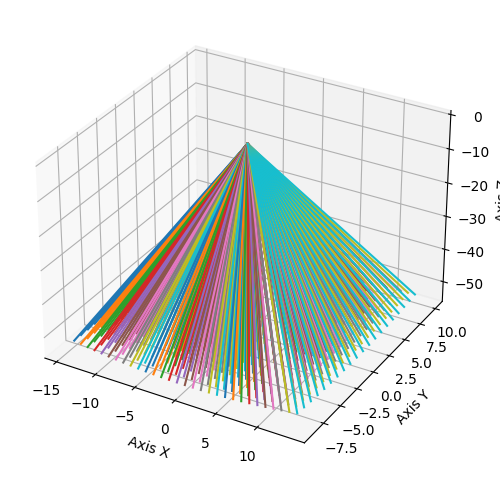

In [10]:
# plot the rays
width = 30
height = 20
focal_length = 55
ray_o, ray_d = generate_rays(width, height, focal_length)



fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Axis X')
ax.set_ylabel('Axis Y')
ax.set_zlabel('Axis Z')

# point = origin + t * direction
o = ray_o #[w*h, 3]
tp = o + ray_d * focal_length #[w*h, 3]

for p1, p2 in zip(o, tp):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]])
plt.show()

## references 

[1] [NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis](https://arxiv.org/pdf/2003.08934v2.pdf)

[2] [Volume Rendering for Developers in scratchapixel.com](https://www.scratchapixel.com/)

In [11]:
## from the scratchapixel.com
def calc_color_through_volume():
    background_color = np.array([1.0, 1.0, 1.0])
    volume_color = np.array([1.0, 0.0, 0.0])
    sigma_a = 0.1 # absorption coefficient
    distance = 10
    
    # internal transmission.
    # Beer-Lambert law
    T = np.exp(-distance*sigma_a)
    
    color_through_volume = T*background_color + (1-T)*volume_color
    return color_through_volume

# print(calc_color_through_volume())

In [12]:
class BaseObject(ABC):
    @abstractmethod
    def integrate(self, rays:torch.Tensor):
        pass

In [13]:
class Camera:
    def __init__(self, whf:tuple[int, int, float], matrix:Optional[torch.Tensor]=None, device='cpu'):
        # super().__init__()
        if matrix is None:
            matrix = torch.tensor([[1.0, 0., 0., 0.], [0., 1.0, 0., 0.], [0., 0., 1.0, 0.], [0., 0., 0., 1.0]]).reshape([4,4]).float().to(device)
        else:
            assert matrix.shape == (4, 4)
        self.whf = whf
        self.matrix = matrix.to(device)

    
    def generate_rays(self, device):
        ray_o, ray_d = generate_rays(*self.whf)
        ray_o = torch.from_numpy(ray_o).float().to(device)
        ray_d = torch.from_numpy(ray_d).float().to(device)
        
        return ray_o + self.matrix[:3, 3], (self.matrix[:3, :3] @ ray_d.unsqueeze(-1)).squeeze(-1)



# only consider the internal transmittance of volume. (no light)
class VolumetricRenderer(nn.Module):
    def __init__(self, camera:Camera, obj:BaseObject):
        super().__init__()
        self.camera = camera
        self.obj:BaseObject = obj

    def forward(self, ray_o, ray_d, tn:float, tf:float, n_bins:int, device='cpu'):
        # !! did not use a stratified sampling in paper.
        t = torch.linspace(tn, tf, n_bins).to(device)

        p = ray_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * ray_d.unsqueeze(1) # [n_rays, 1, 3] + [1, n_bins, 1] * [n_rays, 1, 3] => [n_rays, n_bins, 3]    
        # assert p.shape == (ray_o.shape[0], n_bins, 3)
        
        #
        # Compute internal transmission
        # T = np.exp(-distance*sigma_a)
        # color and density of d though rays
        c, d = self.obj.integrate(p)
        delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10]).to(device))) # [(n_bins-1) + 1]
        # [n_bins, 1] * [n_rays, n_bins, 1]
        
        T = torch.exp(-delta.unsqueeze(0)*d) # [n_rays, n_bins]
        alpha = 1-T
        
        ## Calculate the accumulated transmittance
        acc_t = torch.cumprod(T, 1)
        # acc_t[:, 1:] = acc_t[:, :-1]
        # acc_t[:, 0] = 1.0
        acc_t = torch.cat((torch.ones((acc_t.shape[0], 1), device=device), acc_t[:, :-1]), dim=1)
        
        i_weight = (acc_t * alpha).unsqueeze(-1) # [n_rays, n_bins, 1]        
        return (i_weight * c).sum(1)
        
    def generate_rays(self, device='cpu'):
        ray_o, ray_d = self.camera.generate_rays(device) # [n_rays, 3], [n_rays, 3]
        return ray_o, ray_d
        
    def render(self, tn:float, tf:float, n_bins:int, device='cpu'):
        # create the rays
        ray_o, ray_d = self.generate_rays(device)
        return self.forward(ray_o, ray_d, tn, tf, n_bins, device)
        


In [14]:
class SimpleCube(BaseObject):
    def __init__(self, pos:Tuple[float, float, float], size:float, color:Tuple[float, float, float], density:float):
        self.pos = pos
        self.size = size
        self.color = color
        self.density = density

    def integrate(self, rays:torch.Tensor):

        device = rays.device
        c = torch.tensor(self.color).to(device)
        
        # rays [n_rays, n_bins, 3]
        n_rays = rays.shape[0]
        n_bins = rays.shape[1]
        x = rays[:, :, 0]
        y = rays[:, :, 1]
        z = rays[:, :, 2]

        half_size = self.size/2

        # find the intersection 
        # intersect = (x.abs()< half_size) & (y.abs() < half_size) & (z.abs() < half_size)
        intersect = ((x - self.pos[0]).abs() < half_size) & ((y - self.pos[1]).abs() < half_size) & ((z - self.pos[2]).abs() < half_size)
        # default background black : zeros
        cnd = torch.zeros(n_rays, n_bins, 4).to(device) # 3 colors and 1 density
        color, density = cnd[:, :, :3], cnd[:, :, -1]
        color[intersect] = c
        density[intersect] = self.density
        return color, density


In [15]:
cmatrix = torch.tensor([
    [0.68592,-0.324013,0.651558, 5.258891],
    [0.72767,0.305420,-0.61417,-4.925790],
    [0.0,0.895395,0.445271,3.958309],
    [0.0,0.0,0.0,1.0]]).float()

dist_from_origin = (cmatrix[:3, 3]@cmatrix[:3,3]).sqrt()

In [16]:
width = 400
height = 400
focal_length = 666
n_samples = 100
cube_size = 1.5

tn = dist_from_origin - cube_size
tf = dist_from_origin + cube_size

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


camera = Camera((width, height, focal_length), cmatrix, device)
cube = SimpleCube((0, 0, 0), cube_size, (1.0, 0.0, 0.0), 1)
renderer = VolumetricRenderer(camera, cube)
output_pixel = renderer.render(tn, tf, n_samples, device)

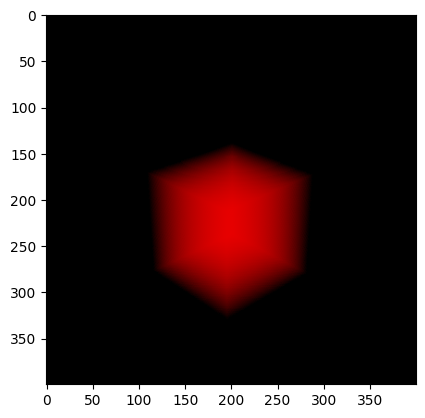

In [18]:
img = output_pixel.reshape(height, width, 3).cpu().numpy()

plt.imshow(img)
plt.show()